In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
pd.set_option("display.max_columns",999)
pd.set_option("display.max_rows",100)

import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import optim

from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side
from src.data_processing import encode_batch_weighted, onehot_batch_decode, onehot_decode, INT_TO_CHAR, get_tensor_dataset, encode_batch, BL62
from src.models import Net, ConvBlock, LinearBlock
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from src.metrics import get_metrics, plot_roc_auc_fold
from src.train_eval import train_loop, nested_kcv_train_nn, evaluate_trained_models_nn
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump
from torch import optim, nn

if torch.cuda.is_available():    
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name())
    device = "cuda:0"
else:
    print('No GPU available, using the CPU instead.')
    device='cpu'
    
from src.partition_tools import pipeline_stratified_kfold
# Load data
cedar = pd.read_csv('../data/cedar_neoepitope_220701_scored.csv')
dataset_5fold = pd.read_csv('../data/cedar_neoepitopes_partition_5fold.csv')
dataset_10fold = pipeline_stratified_kfold('../out/cedar_peps_hobohm_0.925.pep', cedar, k=10, shuffle=True)
sample = dataset_10fold.sample(10)[['Peptide', 'HLA', 'trueHLA_EL_rank', 'agg_label', 'len']]
# other data/stuff
prime = pd.read_excel('../data/other/PRIME_dataset.xlsx', skiprows=2, comment='#')
prime_random=prime.query('StudyOrigin == "Random"')
ics_kl = pkl_load('../output/ics_kl.pkl')
ics_shannon = pkl_load('../output/ics_shannon.pkl')
ics_none = None

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3070 Laptop GPU


In [271]:
cedar_viral_fold

,Peptide,HLA,trueHLA_EL_rank,agg_label,fold,BA_rank,BA_score,Core,Gl,Gp,Icore,Il,Ip,Of,PMIDs,allele,core,dataset,icore,id,label,len,non_aa_pep,non_aa_prot,number_papers_negative,number_papers_positive,peptide_start,peptide_stop,percentage_pos,pred_EL_rank,pred_EL_score,pred_HLA,prot_sequence,responses,subj_responded,subj_tested,target_bin_2,target_qual_corrected,total_count,training,uniprot_id
0,AAAAAAQQIQV,HLA-B07:02,26.7692,0,4,11.9024,0.1632,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27198675,NaN,AAAAAQIQV,cedar,AAAAAAQQIQV,NaN,Negative,11,NaN,NaN,NaN,NaN,NaN,NaN,0.0,5.2822,0.0166,HLA-A68:02,NaN,Negative,NaN,NaN,NaN,NaN,1.0,NaN,NaN
1,AAAAQQIQV,HLA-A02:01,1.9555,0,4,0.3045,0.4709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27198675,NaN,AAAAQQIQV,cedar,AAAAQQIQV,NaN,Negative,9,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.1036,0.6567,HLA-C15:02,NaN,Negative,NaN,NaN,NaN,NaN,1.0,NaN,NaN
2,AAAAQQIQV,HLA-B07:02,4.9092,0,4,0.3045,0.4709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27198675,NaN,AAAAQQIQV,cedar,AAAAQQIQV,NaN,Negative,9,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.1036,0.6567,HLA-C15:02,NaN,Negative,NaN,NaN,NaN,NaN,1.0,NaN,NaN
3,AAFEDLRVL,HLA-B35:03,0.4110,1,8,NaN,NaN,AAFEDLRVL,0.0,0.0,AAFEDLRVL,0.0,0.0,0.0,NaN,HLA-B3503,NaN,viral,NaN,22458.0,NaN,9,0.0,0.0,0.0,1.0,335.0,343.0,NaN,NaN,NaN,NaN,MASQGTKRSYEQMETDGERQNATEIRASVGKMIGGIGRFYIQMCTE...,NaN,1.0,1.0,0.0,0.95,NaN,True,P03466
4,AAFIWIISM,HLA-B35:01,1.3004,0,3,0.1502,0.6560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27198675,NaN,AAFIWIISM,cedar,AAFIWIISM,NaN,Negative,9,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.1756,0.3961,HLA-C12:03,NaN,Negative,NaN,NaN,NaN,NaN,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4362,YYPGKKEPF,HLA-A24:02,0.0965,0,2,0.0750,0.7654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"34270940,34270940",NaN,YYPGKKEPF,cedar,YYPGKKEPF,NaN,Negative,9,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0301,0.9052,HLA-C14:02,NaN,"Negative,Negative",NaN,NaN,NaN,NaN,2.0,NaN,NaN
4363,YYPPSQIAQL,HLA-A24:02,0.0566,1,4,0.0780,0.7614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26048577,NaN,YYPPSQIAL,cedar,YYPPSQIAQL,NaN,Positive,10,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0418,0.8745,HLA-C14:02,NaN,Positive_all,NaN,NaN,NaN,NaN,1.0,NaN,NaN
4364,YYSKNLNSF,HLA-A24:02,0.0033,1,0,0.0086,0.8124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28423700,NaN,YYSKNLNSF,cedar,YYSKNLNSF,NaN,Positive,9,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0033,0.9896,HLA-A24:02,NaN,Positive_all,NaN,NaN,NaN,NaN,1.0,NaN,NaN
4365,YYSKNLNSFF,HLA-A24:02,0.0310,1,0,0.0122,0.7758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"28423700,28423700",NaN,YYSKNLNSF,cedar,YYSKNLNSFF,NaN,Positive,10,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0310,0.9225,HLA-A24:02,NaN,"Positive_all,Positive_all",NaN,NaN,NaN,NaN,2.0,NaN,NaN


# dataset checks

In [2]:
mixed=pd.read_csv('../data/script_traindata/cedar_hp_mixed_10fold.csv')

In [3]:
ct=mixed.groupby('agg_label')['Peptide'].count()
ct[1]/ct[0]

0.10072497300632423

## Prep Viral data

In [259]:
viral = pd.read_csv('../data/heli_viral', sep ='\s')
print(viral.columns)
viral = viral.rename(columns = {'peptide_length':'len'})
# [['id', 'Icore', 'allele', 'Core', 'Rnk_EL', 'target', 'target_bin_2', 'target_qual_corrected', 'len', 'allele_mod']]
# Recover the peptide sequence
viral['Peptide']= viral.apply(lambda x: x['prot_sequence'][x['peptide_start']:x['peptide_stop']+1], axis=1)
# Quick checks that it makes sense
viral[['Peptide', 'Icore', 'Core']]

Index(['id', 'Icore', 'allele', 'prot_sequence', 'Core', 'Of', 'Gp', 'Gl',
       'Ip', 'Il', 'Rnk_EL', 'uniprot_id', 'number_papers_positive',
       'number_papers_negative', 'subj_tested', 'subj_responded', 'target',
       'target_bin_2', 'target_qual_corrected', 'peptide_length',
       'peptide_start', 'peptide_stop', 'non_aa_pep', 'non_aa_prot',
       'allele_mod', 'training'],
      dtype='object')


,Peptide,Icore,Core
0,TVTSTPVQGR,TVTSTPVQGR,TVTSTPVQR
1,TVYPPSSTAK,TVYPPSSTAK,TVYPPSSTK
2,AEWPTFNVGW,AEWPTFNVGW,AEWPTNVGW
3,ILDSFDPLV,ILDSFDPLV,ILDSFDPLV
4,RLIVFPDLGV,RLIVFPDLGV,RLIVFPLGV
...,...,...,...
16798,LLHERLDEF,LLHERLDEF,LLHERLDEF
16799,LFITSTHVI,LFITSTHVI,LFITSTHVI
16800,FTISDSATF,FTISDSATF,FTISDSATF
16801,YLQQRTFLL,YLQQRTFLL,YLQQRTFLL


In [254]:
cedar_hlas = cedar.HLA.unique()
common_hlas = [x for x in viral.allele_mod.unique() if x in cedar_hlas]
viral_not = [x for x in viral.allele_mod.unique() if x not in cedar_hlas]
# Sampling from viral:
samples = []
for target in [0, 1]:
    k = 10 if target == 1 else 15
    for allele in common_hlas:
        tmp = viral.query('allele_mod == @allele and target == @target')
        n = min(len(tmp), k)
        ss= tmp.sample(n, random_state=13)
        samples.append(ss)
viral_samples = pd.concat(samples).reset_index(drop=True)
viral_samples['dataset'] = 'viral'
viral_samples.rename(columns = {'Rnk_EL':'trueHLA_EL_rank',
                                'target':'agg_label',
                                'allele_mod':'HLA'}, inplace=True)
# Concatenate and saving for hobohm
cedar_viral = pd.concat([cedar,viral_samples]).reset_index(drop=True)
cedar_viral['Peptide'].to_csv('../../../kern_dist/data/cedar_viral.pep', index=False, header=False)

In [260]:
from src.partition_tools import pipeline_stratified_kfold
cedar_viral_fold = pipeline_stratified_kfold('../../../kern_dist/out/cedar_viral.pep_0.9.pep', cedar_viral, k=10)
cedar_viral_fold.groupby(['fold', 'agg_label']).count()

Peptide  HLA  trueHLA_EL_rank  BA_rank  BA_score  Core  Gl  \
fold agg_label                                                               
0    0              320  320              320      282       282    38  38   
     1              110  110              110       78        78    32  32   
1    0              313  313              313      270       270    43  43   
     1               94   94               94       56        56    38  38   
2    0              317  317              317      281       281    36  36   
     1              102  102              102       62        62    40  40   
3    0              328  328              328      288       288    40  40   
     1              107  107              107       69        69    38  38   
4    0              333  333              333      293       293    40  40   
     1              104  104              104       57        57    47  47   
5    0              339  339              339      298       298    41  41   
     1              109  109              109       67        67    42  42   
6    0              326  326              326      289       289    37  37   
     1               99   99               99       55        55    44  44   
7    0              314  314              314      279       279    35  35   
     1              102  102              102       68        68    34  34   
8    0              303  303              303      265       265    38  38   
     1              105  105              105       69        69    36  36   
9    0              315  315              315      282       282    33  33   
     1              100  100              100       72        72    28  28   

                Gp  Icore  Il  Ip  Of  PMIDs  allele  core  dataset  icore  \
fold agg_label                                                               
0    0          38     38  38  38  38    282      38   282      320    282   
     1          32     32  32  32  32     78      32    78      110     78   
1    0          43     43  43  43  43    270      43   270      313    270   
     1          38     38  38  38  38     56      38    56       94     56   
2    0          36     36  36  36  36    281      36   281      317    281   
     1          40     40  40  40  40     62      40    62      102     62   
3    0          40     40  40  40  40    288      40   288      328    288   
     1          38     38  38  38  38     69      38    69      107     69   
4    0          40     40  40  40  40    293      40   293      333    293   
     1          47     47  47  47  47     57      47    57      104     57   
5    0          41     41  41  41  41    298      41   298      339    298   
     1          42     42  42  42  42     67      42    67      109     67   
6    0          37     37  37  37  37    289      37   289      326    289   
     1          44     44  44  44  44     55      44    55       99     55   
7    0          35     35  35  35  35    279      35   279      314    279   
     1          34     34  34  34  34     68      34    68      102     68   
8    0          38     38  38  38  38    265      38   265      303    265   
     1          36     36  36  36  36     69      36    69      105     69   
9    0          33     33  33  33  33    282      33   282      315    282   
     1          28     28  28  28  28     72      28    72      100     72   

                id  label  len  non_aa_pep  non_aa_prot  \
fold agg_label                                            
0    0          38    282  320          38           38   
     1          32     78  110          32           32   
1    0          43    270  313          43           43   
     1          38     56   94          38           38   
2    0          36    281  317          36           36   
     1          40     62  102          40           40   
3    0          40    288  328          40           40   
     1          38     69  107          38         

In [258]:
cedar_viral_fold.to_csv('../data/script_traindata/cedar_viral_10fold.csv', index=False)

## Make new cedar-HP dataset with ranks 5-20%

In [95]:
# Read and concat
cedar['dataset'] = 'cedar'
hp_120 = pd.read_csv('../output_xls/subsampled/humanprot_sub_N55_seed13_cons_True_3_1575779149_scored.txt').drop(columns=['wt'])
hp_120['len'] = hp_520.Peptide.apply(len)
hp_120['agg_label'] = 0
hp_120['percentage_pos'] = 0
hp_120['dataset'] = 'hp'
hp_120['total_count'] = 3
cols = ['Peptide', 'HLA', 'dataset', 'total_count', 'percentage_pos', 'agg_label', 'len', 'trueHLA_EL_rank', 'core', 'icore', 'BA_score', 'BA_rank']
cedar_mixed_hp120 = pd.concat([cedar[cols], hp_120.rename(columns={'EL_Rank':'trueHLA_EL_rank',
                                                                   'BA-score':'BA_score',
                                                                   'BA_Rank':'BA_rank'})[cols]]).reset_index(drop=True)

In [83]:
# Save for kerndist
cedar_mixed_hp120['Peptide'].to_csv('../../../kern_dist/data/cedar_mixed_hp120.pep', index=False, header=False)

In [97]:
cedar_mixed_hp120_hobohm = pipeline_stratified_kfold('../../../kern_dist/out/cedar_mixed_hp120.pep_0.9.pep', cedar_mixed_hp120,
                                                     k=10)

In [100]:
cedar_mixed_hp120_hobohm.to_csv('../data/script_traindata/cedar_hp_mixed_rank120_10fold.csv', index=False)

# Peptide AA prop values

In [4]:
import peptides
from datetime import datetime as dt
from src.data_processing import get_aa_properties

start = dt.now()
vals = get_aa_properties(dataset_10fold)[0][['Peptide', 'HLA', 'agg_label', 'fold','len', 'trueHLA_EL_rank',
 'aliphatic_index', 'boman', 'charge_7_4', 'charge_6_65',
 'hydrophobicity', 'isoelectric_point', 'PD2', 'VHSE1', 'VHSE2', 'VHSE3',
 'VHSE4', 'VHSE5', 'VHSE6', 'VHSE7', 'VHSE8']]
end = dt.now()
elapsed = divmod((end-start).seconds, 60)
print(f'Time elapsed: {elapsed[0]}m {elapsed[1]}s or {(end-start).microseconds} ms')

Time elapsed: 0m 2s or 993746 ms


In [206]:
# Checking distributions 
from scipy.stats import mannwhitneyu, ttest_ind

def plot_aaprops(vals, label_column='agg_label', rank_column='trueHLA_EL_rank', title = 'Different AA properties on CEDAR\nONE-SIDED MW-U and Welch tests'):
    pal = sns.color_palette('hsv', n_colors = 13)
    sns.set_palette([pal[-4], pal[-1]])
    f,a = plt.subplots(8,2, figsize = (10, 32))
    ax = a.ravel()
    
    hue = [label_column]
    for i,key in enumerate([rank_column, 'aliphatic_index', 'boman', 'charge_7_4', 'charge_6_65', 'hydrophobicity', 
                            'isoelectric_point', 'PD2',  'VHSE1', 'VHSE2', 'VHSE3', 'VHSE4', 'VHSE5', 'VHSE6', 'VHSE7', 'VHSE8']):
        gb=vals.groupby(label_column)[key].agg(['mean', 'median'])
        med_0 = gb.loc[0,'median']
        med_1 = gb.loc[1, 'median']
        sns.histplot(data = vals, x = key, hue=label_column, alpha = 0.4, kde=True, ax=ax[i], legend=True, hue_order=[0,1])
        # Reset max ylim
        upper = ax[i].get_ylim()[1]
        ax[i].set_ylim([0, upper* 1.15])
        
        # Mann Whitney U test
        pos, neg = vals.query(f'{label_column}==1')[key].values, vals.query(f'{label_column}==0')[key].values
        
        alt_t = 'greater' if pos.mean()>neg.mean() else 'less'
        """
        ‘less’: the distribution underlying x is stochastically less than the distribution underlying y, i.e. F(u) > G(u) for all u.
        """
        alt_mw = 'less' if pos.mean() < neg.mean() else 'greater'
        
        _, pval_mw = mannwhitneyu(pos, neg, alternative=alt_mw)
        _, pval_t = ttest_ind(pos,neg, equal_var = False, alternative=alt_t)
        
        
        sig_mw = f'ns; p={pval_mw:.3f}' if pval_mw>0.05 else f'*, p={pval_mw:.2e}'
        sig_t = f'ns; p={pval_t:.3f}' if pval_t>0.05 else f'*, p={pval_t:.2e}'
        ax[i].set_title(f'MW-U: {sig_mw}; Welch test: {sig_t}')
        # Reset ax if HLA rank
        if key == rank_column:
            ax[i].set_xlim([0,20])
            
        # Drawing axvlines
        ax[i].axvline(x=med_0, label = 'Median 0', ls = '--', lw = '.65', color='b' )
        ax[i].axvline(x=med_1, label = 'Median 1', ls = '--', lw = '.65', color='m')
        # Get the fucking rectangles from sns plots
        legend = ax[i].get_legend()
        handles = legend.legendHandles
        # Combine to the fucking lines from plt/ax plots
        handles.extend(ax[i].get_legend_handles_labels()[0])
        # Set the labels manually like a dog
        labels = ["Label = 0", "Label = 1", "Median 0", "Median 1"]
        # Reset the legend manually like a dog
        ax[i].legend(handles = handles, labels = labels)
    f.suptitle(f'{title}', fontweight= 'semibold',fontsize=15)
    plt.tight_layout()
    plt.subplots_adjust(top=0.955)

In [ ]:
start = dt.now()
vals_viral = get_aa_properties(viral, seq_col = 'Core')[0][['Core', 'Rnk_EL','allele', 'target', 'aliphatic_index', 'boman', 'charge_7_4', 'charge_6_65', 'hydrophobicity', 'isoelectric_point', 'PD2', 'VHSE1', 'VHSE2', 'VHSE3', 'VHSE4', 'VHSE5', 'VHSE6', 'VHSE7', 'VHSE8']]
end = dt.now()
elapsed = divmod((end-start).seconds, 60)
print(f'Elapsed: {elapsed[0]} minutes {elapsed[1]} seconds.')


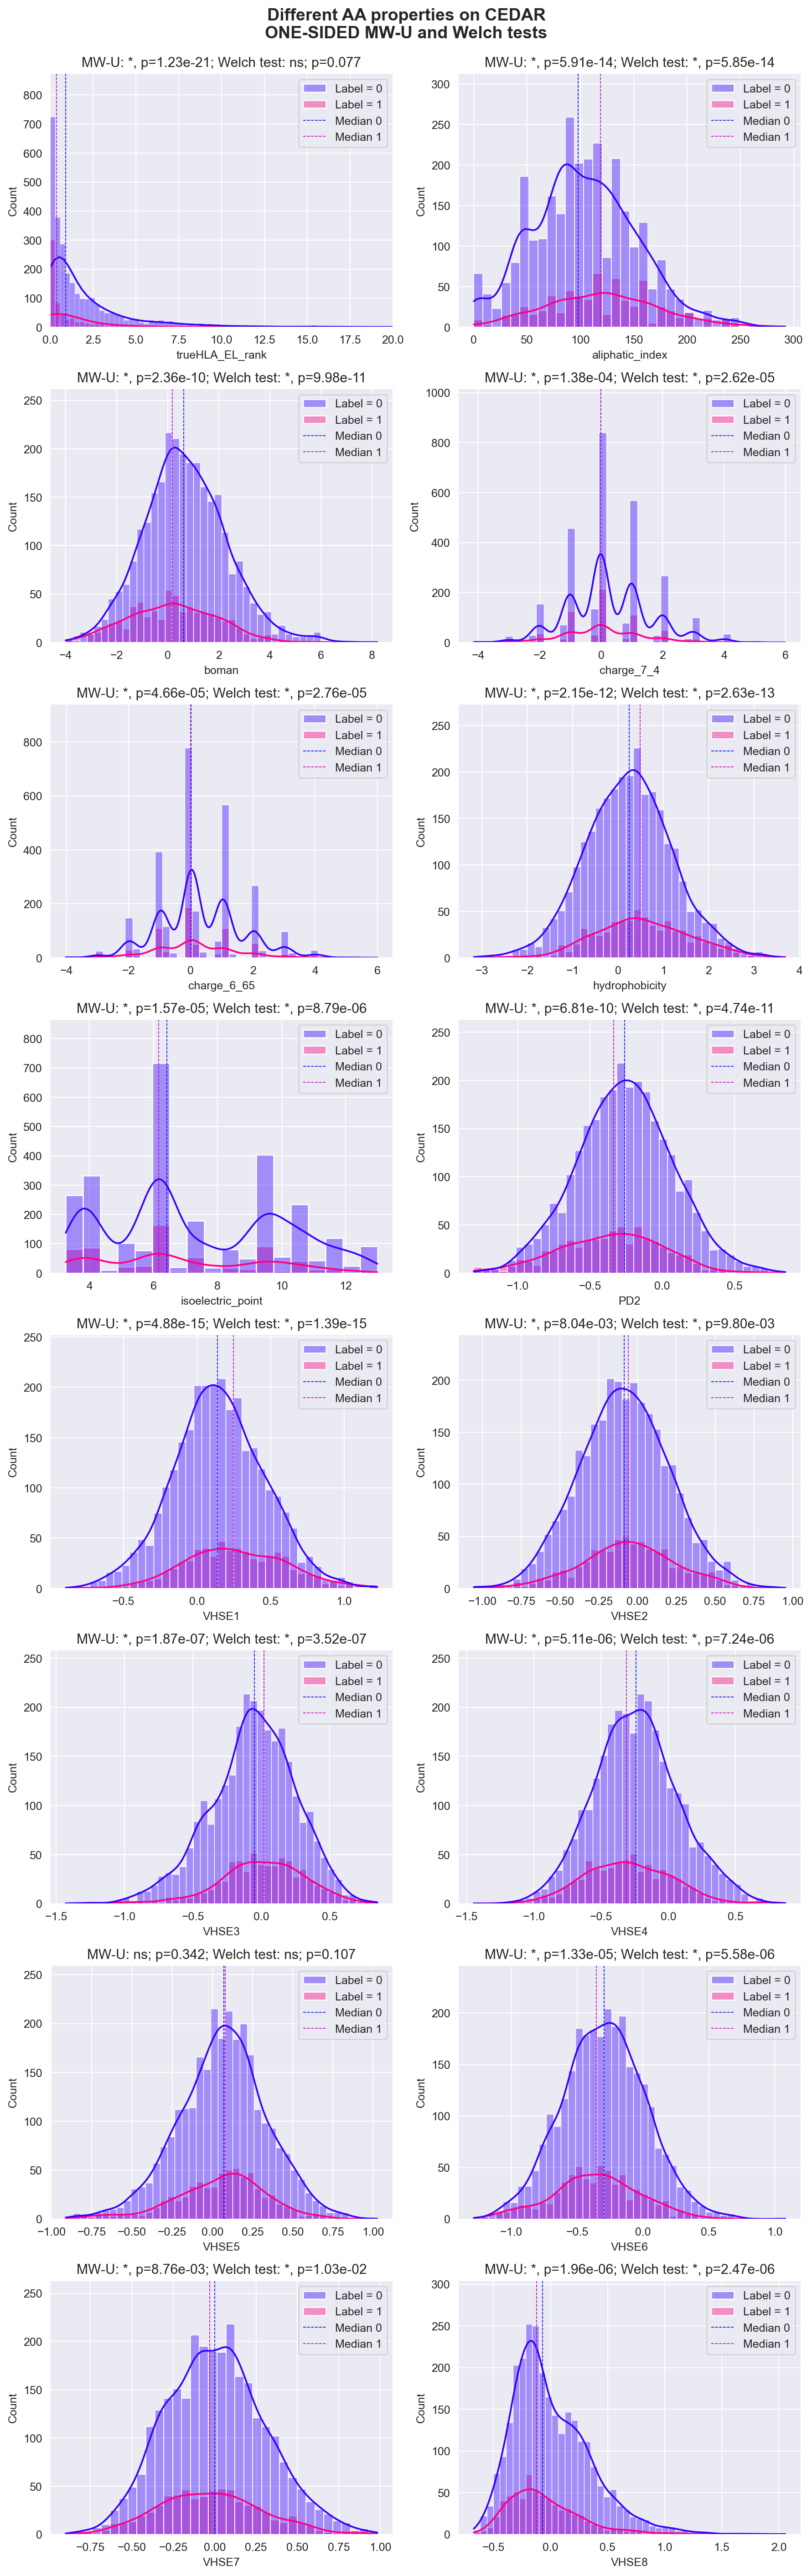

In [207]:
plot_aaprops(vals)

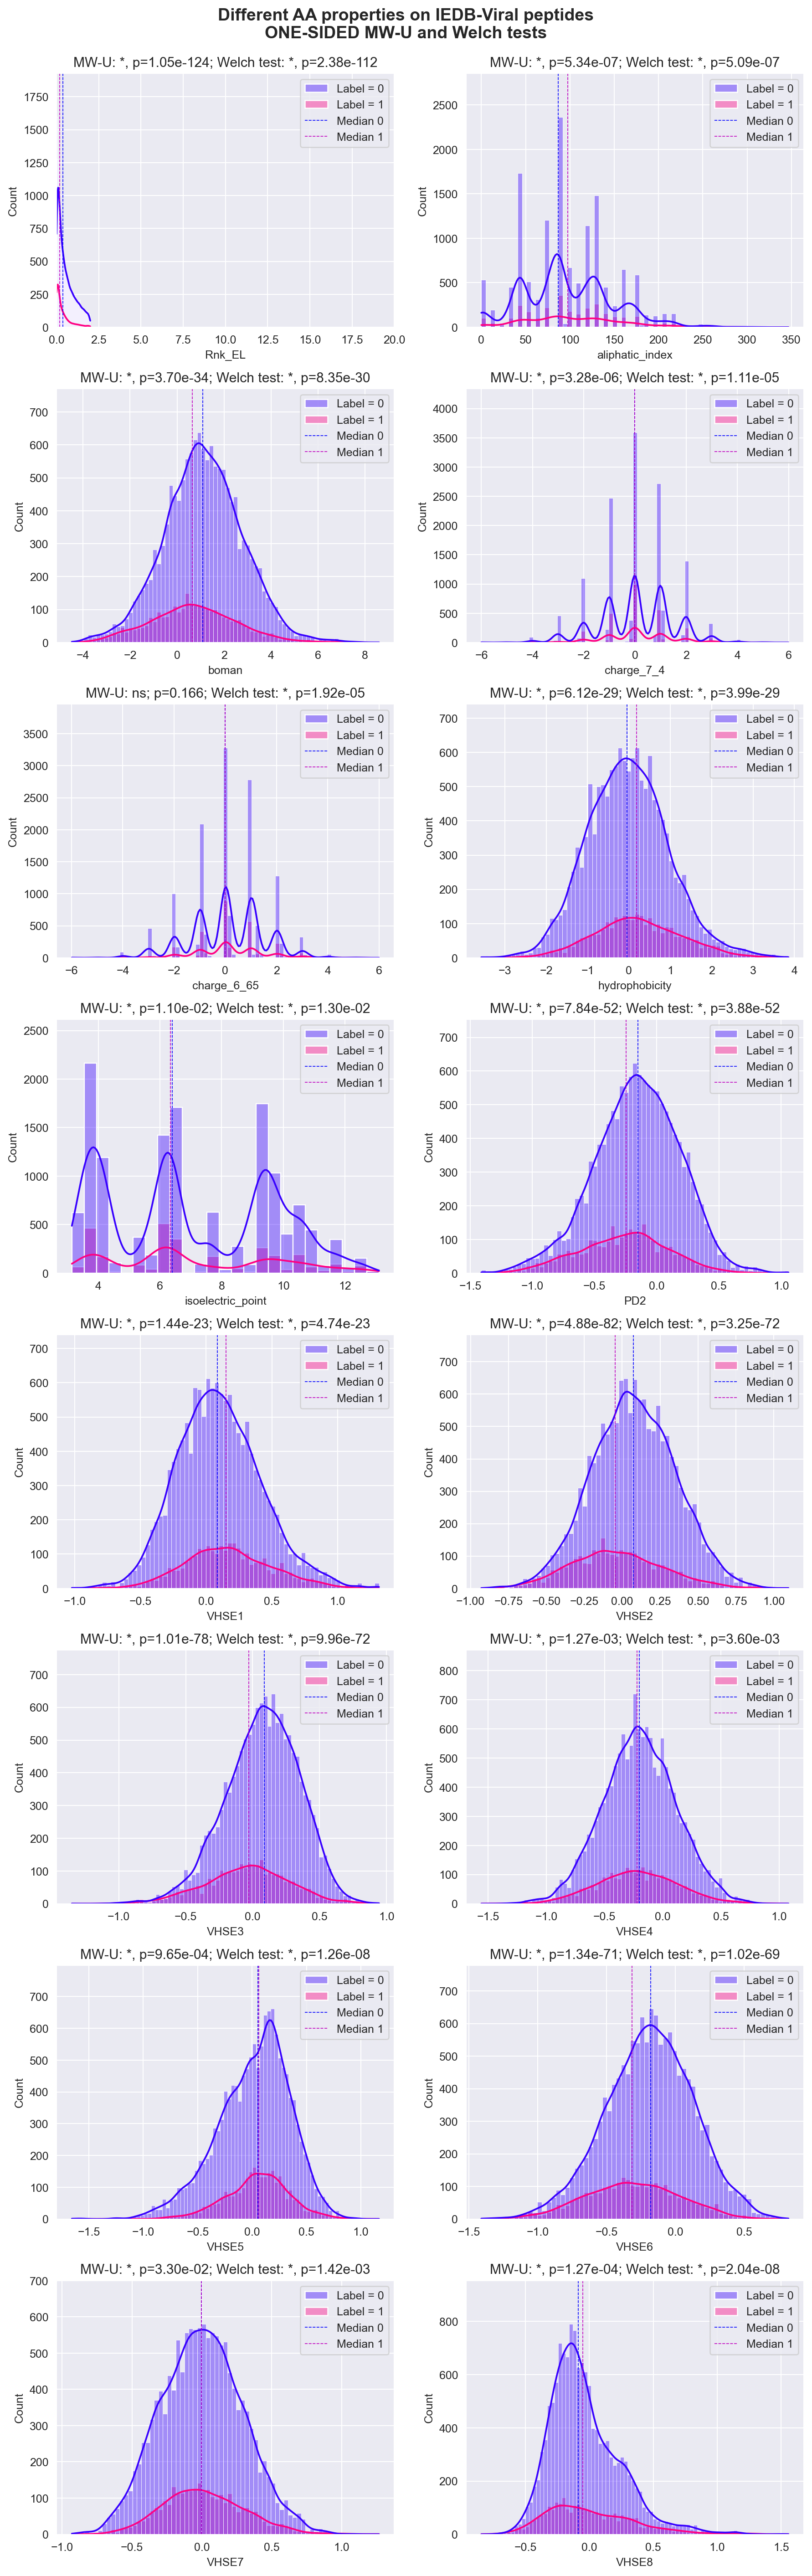

In [208]:
plot_aaprops(vals_viral, label_column='target', rank_column = 'Rnk_EL', title = 'Different AA properties on IEDB-Viral peptides\nONE-SIDED MW-U and Welch tests')

# Kwargs stuff

In [6]:
from src.data_processing import BL62FREQ_VALUES, BL62_VALUES, batch_compute_frequency, encode_batch_weighted, encode_batch, get_array_dataset, standardize
# pass encoding_kwarg dict in nested_kcv_train fct, and pass it as **kwargs in the get_array_dataset call within the function

kwargs = {'max_len':12,
          'encoding':'blosum',
          'blosum_matrix':BL62FREQ_VALUES,
          'mask':False,
          'add_rank':True,
          'add_aaprop':True}
x,y = get_array_dataset(sample, ics_shannon, **kwargs)
x1,y1 = get_array_dataset(sample, ics_shannon, encoding='blosum', blosum_matrix=BL62FREQ_VALUES, add_aaprop=False, add_rank=False)
xv,yv = get_array_dataset(dataset_10fold.sample(5), ics_shannon, **kwargs)

[0.08771972 0.04159473 0.03273592 0.02829032 0.03218401 0.07464311
 0.04152333 0.07766024 0.03012701 0.04919218 0.0588269  0.0627955
 0.04889473 0.02878163 0.02966183 0.04866522 0.04200821 0.02207745
 0.02881325 0.06143174] (10, 20)
(10, 1)
(10, 21)
(10, 15)
(10, 36)
[0.08771972 0.04159473 0.03273592 0.02829032 0.03218401 0.07464311
 0.04152333 0.07766024 0.03012701 0.04919218 0.0588269  0.0627955
 0.04889473 0.02878163 0.02966183 0.04866522 0.04200821 0.02207745
 0.02881325 0.06143174] (10, 20)
[0.02671135 0.02098486 0.04763922 0.02151749 0.0603372  0.03467344
 0.02323461 0.01808391 0.02259019 0.0293188  0.02558467 0.02455281
 0.02696487 0.08416983 0.05863686 0.03994723 0.02930952 0.06501223
 0.03933642 0.03601344] (5, 20)
(5, 1)
(5, 21)
(5, 15)
(5, 36)


In [10]:
x_copy = x.copy()

In [11]:
x_copy, xv = standardize(x_copy, xv)

## hyperparams grid

In [15]:
hp = {'a': [1,2,3],
      'b': [4,5,6],
      'c': [7,8,9]}
for k,v in hp.items():
    print(k,v)

a [1, 2, 3]
b [4, 5, 6]
c [7, 8, 9]


In [21]:
from sklearn.model_selection import ParameterGrid
import random 
for k in list(ParameterGrid(hp)):
    k['result_value'] = random.randint(0, 200)

# mean rocs

In [65]:
pd.DataFrame(list(ParameterGrid(hp)))

,a,b,c
0,1,4,7
1,1,4,8
2,1,4,9
3,1,5,7
4,1,5,8
5,1,5,9
6,1,6,7
7,1,6,8
8,1,6,9
9,2,4,7


In [56]:
from src.metrics import get_mean_roc_curve
d = {}
for fold in range(8):
    d[fold] = {}
    d[fold]['valid'] = {}
    n = np.random.randint(500, 550)
    x_curve = np.arange(0,n)
    y_curve = np.random.rand(n) * np.arange(0,n)
    d[fold]['valid']['roc_curve'] = [x_curve, y_curve]
    print(n)

543
506
526
504
509
517
522
527


In [58]:
x, y, lower, upper = get_mean_roc_curve(d, extra_key='valid')

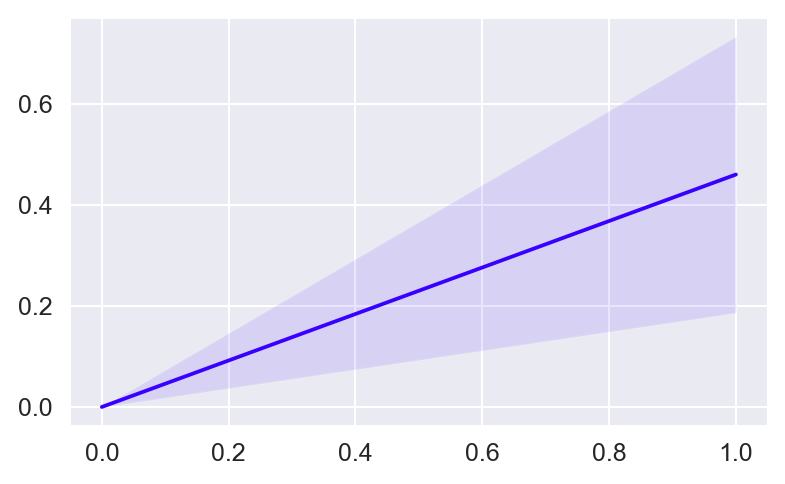

In [62]:
f,ax = plt.subplots(1,1, figsize=(5,3))
sns.lineplot(x=x, y=y, ax=ax)
ax.fill_between(x, lower, upper, alpha=0.1)

In [45]:
np.stack([np.random.rand(100, 3) for _ in range(5)]).mean(axis=0).shape

(100, 3)

In [28]:
pd.DataFrame(k, index=[0])

,a,b,c,result_value
0,3,6,9,39


# Wrapper with encoding kwargs stuff

In [7]:
md = LinearBlock(1,2)
# Use this to do the switch in train wrapper
issubclass(md.__class__, nn.Module)

True

In [8]:
# Wrapper stuff : 
def kcv_wrapper(train_dataset,dataset_name, model_type, weighting, weighting_name, add_rank):
    """
    TODO: HERE BASICALLY MERGE ALL THE DIFFERENT ENCODING ARGS INTO A DICT, AND PASS IT AS ENCODINGKWARGS TO NESTED_KCV_TRAIN!
    """
    # dataset_name = f'{train_dataset=}'.split('=')[0]
    # print(dataset_name)
    ic_name = f'{weighting=}'.split('=')[0]
    rank_name = f'EL_{add_rank}'
    model_name = model_type.__name__

    if model_name == 'LinearBlock':
        results = np.random.randint(100,200, size=[5]) # HERE REPLACE WITH RESULTS = KCV SOME SHIT
    else:
        results = np.random.randint(0,5, size=[5])
    outname = model_name+rank_name+weighting_name+dataset_name
    return outname, results

results = []
# Maybe keep the kwargs as loop, and parallelize models & datasets instead?
# Not the most efficient but more readable / easy to write in terms of arguments because of 
for train_dataset, dataset_name in zip([dataset_5fold, dataset_10fold], ['cedar', 'cedar_hp']):
    for model in [RandomForestClassifier, XGBClassifier, LogisticRegression, LinearBlock]:
        kcv_wrapper_ = partial(kcv_wrapper, train_dataset = train_dataset, dataset_name = dataset_name, model_type = model)
        output = Parallel(n_jobs=4)(delayed(kcv_wrapper_)(weighting=weighting, weighting_name=weighting_name, add_rank=add_rank) for (weighting, weighting_name), add_rank in \
                                    product(zip([ics_shannon, ics_kl, ics_none], ['shannon','kl','none']), [True, False]))
        results.extend(output)
        

NameError: name 'RandomForestClassifier' is not defined

In [ ]:
d = {'a':1, 'b':2, 'c':3}
name = '_'.join([f'{k}{v}' for k,v in d.items() if k!='b'])
name

In [ ]:
encoding_kwargs = {'max_len':12,
                   'encoding':1,
                   'blosum_matrix':2,
                   'mask': 3,
                   'add_rank': 4,
                   'add_aaprop': 5,
                   'remove_pep':6,
                   'standardize': 7}
outname = {'model':'rf'}
# Save the parameter name as a massive string to tag the output.
outname.update({k:v for k,v in encoding_kwargs.items() if k!='blosum_matrix'})
'_'.join([f"{k.replace('add_','')}{v}" for k,v in outname.items()])

In [ ]:
import xgboost
xgboost.XGBClassifier().__class__.__name__

# DEFINE LOOPS AND COMBINATIONS

## test of mega product:

Flattening + Running in parallel & re-get the proper params into the right place

In [263]:
from itertools import product

In [272]:
from itertools import product
from src.utils import flatten_product
encode_blosum_zip = zip(['onehot', 'blosum', 'blosum'], [None, 1, 2])
# Weighting zip
ics_mask_zip = zip([1, 2, 3, 4], ['Shannon', 'KL', 'None', 'Mask'],
                            [False, False, False, True])
# True/False zips for add_rank, add_aaprop, remove_pep
features_zip = zip([True, True, True, False, False, False],
                   [True, True, False, True, True, False],
                   [False, True, False, False, True, False])
 
# Lone conditions (to be producted so not zipped)
train_datasets = [1, 2, 3, 4]
standardize_ = [True, False]

conditions = product(train_datasets, 
                     product(encode_blosum_zip, 
                             product(ics_mask_zip, 
                                     product(features_zip, 
                                             product(standardize_)))))

# train_dataset, encoding, blosum matrix, ics dict, ics name, mask, add rank, add prop, remove pep, standardize
conditions = list(list(flatten_product(x)) for x in conditions)
len(conditions), conditions

(576,
 [[1, 'onehot', None, 1, 'Shannon', False, True, True, False, True],
  [1, 'onehot', None, 1, 'Shannon', False, True, True, False, False],
  [1, 'onehot', None, 1, 'Shannon', False, True, True, True, True],
  [1, 'onehot', None, 1, 'Shannon', False, True, True, True, False],
  [1, 'onehot', None, 1, 'Shannon', False, True, False, False, True],
  [1, 'onehot', None, 1, 'Shannon', False, True, False, False, False],
  [1, 'onehot', None, 1, 'Shannon', False, False, True, False, True],
  [1, 'onehot', None, 1, 'Shannon', False, False, True, False, False],
  [1, 'onehot', None, 1, 'Shannon', False, False, True, True, True],
  [1, 'onehot', None, 1, 'Shannon', False, False, True, True, False],
  [1, 'onehot', None, 1, 'Shannon', False, False, False, False, True],
  [1, 'onehot', None, 1, 'Shannon', False, False, False, False, False],
  [1, 'onehot', None, 2, 'KL', False, True, True, False, True],
  [1, 'onehot', None, 2, 'KL', False, True, True, False, False],
  [1, 'onehot', None, 2, 

In [276]:
def fct(model, train_dataset,
        encoding, blosum_matrix,
        ics_dict, ics_name, 
        mask, add_rank, add_aaprop, 
        remove_pep, standardize):
    print('\nmodel,', model,
          '\ntrain_dataset,', train_dataset,
          '\nics_dict,', ics_dict,
          '\nics_name,', ics_name,
          '\nencoding,', encoding,
          '\nblosum_matrix,', blosum_matrix,
          '\nmask,', mask,
          '\nadd_rank,', add_rank,
          '\nadd_aaprop,', add_aaprop,
          '\nremove_pep,', remove_pep,
          '\nstandardize)', standardize)
    output = [str(model)+'  pleasework', str(train_dataset)+'  data',
        str(encoding)+'  enc', str(blosum_matrix)+'  blsm',
        str(ics_dict)+'  ic', str(ics_name)+'  icname', 
        str(mask)+'  mask', str(add_rank)+'  rank', str(add_aaprop)+'  prop', 
        str(remove_pep)+'  remove', str(standardize)+'  std']
    return output


In [278]:
from functools import partial
from joblib import Parallel, delayed


wrapper = partial(fct, model = 'xd')
xd = []
output = Parallel(n_jobs=15)(delayed(wrapper)(train_dataset=train_dataset, encoding=encoding, 
                                        blosum_matrix=blosum_matrix, ics_dict=ics_dict, ics_name=ics_name,  
                                        mask=mask, add_rank=add_rank, add_aaprop=add_aaprop,  remove_pep=remove_pep, standardize=standardize) 
                       for (train_dataset, encoding, blosum_matrix, ics_dict, ics_name, mask, add_rank, add_aaprop, remove_pep, standardize) in conditions)
xd.extend(output)
print(len(xd))

576


## output checks

In [307]:
xd=product([1], product([2], product([3], product([4]))))
list(list(flatten_product(x)))

[1, 2, 3, 4]

In [310]:
l1 = ['a','b','c']
l2 = {'a':1, 'b':2, 'c':3, 'd':4}
assert all([x in l2.keys() for x in l1]), 'xd'

In [301]:
df=pd.DataFrame({'a':[1,2,3], 'b':[4,5,6], 'param_c':[12,145,52], 'score_avg': [1204, 312, 1302]}, index = [100, 23, 1243])
best_idx = df['score_avg'].argmax()
params_cols = [x for x in df.columns if 'score' not in x]
best_params = df.iloc[best_idx][params_cols].to_dict()
best_params

{'a': 3, 'b': 6, 'param_c': 52}

In [303]:
cdts = {'c1': 1, 'c2':'onehot', 'c3':'xd', 'best_params':list(best_params)}
pd.DataFrame(cdts)

,c1,c2,c3,best_params
0,1,onehot,xd,a
1,1,onehot,xd,b
2,1,onehot,xd,param_c


In [312]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.set_params(**{'ccp_alpha':1e-9, 'max_depth':3})

RandomForestClassifier(ccp_alpha=1e-09, max_depth=3)

# Debugging

In [319]:
from src.utils import pkl_load, pkl_dump
d1 = pkl_load('../output/tuning/trainsetcedar_modelRF_weightShannon_max_len12_encodingonehot_maskFalse_add_rankTrue_add_aapropTrue_remove_pepFalse_standardizeTrue.pkl')
d2 = pkl_load('../output/tuning/tune_results_models.pkl')

In [320]:
len(d2['RandomForestClassifier'])

1

In [324]:
d2['RandomForestClassifier'][0]

(      ccp_alpha  max_depth  n_estimators  score_avg_valid_auc  \
 0  1.000000e-10        3.0           100             0.675401   
 1  1.000000e-10        NaN           100             0.694997   
 
    score_avg_train_auc  score_avg_valid_auc_01  score_avg_train_auc_01  \
 0             0.755862                0.556684                0.623984   
 1             1.000000                0.564253                1.000000   
 
    score_avg_valid_f1score  score_avg_train_f1score  score_test_auc  \
 0                 0.000000                      0.0        0.727053   
 1                 0.121434                      1.0        0.756096   
 
    score_test_auc_01  score_test_f1  
 0           0.603535       0.000000  
 1           0.598673       0.175676  ,
 'trainsetcedar_modelRF_weightShannon_max_len12_encodingonehot_maskFalse_add_rankTrue_add_aapropTrue_remove_pepFalse_standardizeTrue',
 {'trainset': 'cedar',
  'model': 'RF',
  'weight': 'Shannon',
  'max_len': 12,
  'encoding': 'onehot'

In [332]:
divmod(127,60)

(2, 7)

In [334]:
time = 7260
m,s = divmod(time, 60)
h,m = divmod(m, 60)
print(f'{h} hours, {m} minutes, {s} seconds')

2 hours, 1 minutes, 0 seconds


In [329]:
import math
math.isnan(d2['RandomForestClassifier'][0][2]['best_params']['max_depth'])

True